In [1]:
from load_driver_data import load_driver_data
from load_user_data import load_user_data
from matplotlib import pyplot as plt
import math

In [2]:
def draw(officer, table):
    """
    画出所有用户的位置

    参数
    ----------
    officer : 调度员对象
    table : 司机与乘客的绑定表
    """
    coordinates = [i["coordinate"] for i in officer.users_backup]
    x,y = zip(*coordinates)
    plt.scatter(x,y)
    # 画出所有司机的位置
    if officer.type == 'receive':
        coordinates = [i["coordinate"] for i in officer.drivers_backup]
        x,y = zip(*coordinates)
        plt.scatter(x,y,c = 'y')
    # 连接已经分配好的司机和用户
    for user,driver in table:
        x,y = zip(user["coordinate"],driver["coordinate"])
        plt.plot(x,y,color='b')
    plt.xticks(np.arange(104.000,104.150,0.025))
    plt.yticks(np.arange(30.600,30.750,0.025))
    plt.gca().set_aspect(1)
    plt.show()

def is_driver(data):
    return "driver_id" in data.keys()

def is_user(data):
    return "id" in data.keys()

def get_distance(a,b):
    a = a["coordinate"]
    b = b["coordinate"]
    return math.hypot(a[0]-b[0], a[1]-b[1])

In [3]:
data_model = {}
users = load_user_data()
drivers = load_driver_data()

In [4]:
INF = 999999
points = [0] + drivers + users
drivers_cnt = len(drivers)
users_cnt = len(users)
matrix = []
for fr in points:
    ls = []
    for to in points:
        if fr == 0:
            ls.append(INF)
        elif is_user(fr) and to==0:
            ls.append(0)
        elif is_driver(fr) and to==0:
            ls.append(INF)
        elif is_driver(to):
            ls.append(INF)
        elif is_user(to):
            ls.append(round(get_distance(fr, to)*100000))
    matrix.append(ls)
data_model['distance_matrix'] = matrix

In [5]:
data_model['demands'] = [0 for i in range(drivers_cnt+1)] + [i["size"] for i in users]
data_model['vehicle_capacities'] = [i["sites"] for i in drivers]
data_model['num_vehicles'] = drivers_cnt
data_model['starts'] = [i for i in range(1, drivers_cnt+1)]
data_model['ends'] = [0 for i in range(drivers_cnt)]

In [6]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    total_distance = 0
    total_load = 0
    table = []
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        ls = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            ls.append(node_index)
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
        table.append(ls)
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))
    return table

In [7]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
manager = pywrapcp.RoutingIndexManager(len(data_model['distance_matrix']),
                                           data_model['num_vehicles'], 
                                           data_model['starts'],
                                           data_model['ends'])
routing = pywrapcp.RoutingModel(manager)
# Create and register a transit callback.
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data_model['distance_matrix'][from_node][to_node]
transit_callback_index = routing.RegisterTransitCallback(distance_callback)
# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)


In [ ]:
    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data_model['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(
        demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data_model['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')
    routing.SetFixedCostOfAllVehicles(500000)
    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.FromSeconds(1)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)
    table = print_solution(data_model, manager, routing, solution)

Route for vehicle 0:
 1 Load(0) ->  93 Load(2) ->  59 Load(3) ->  116 Load(4) ->  64 Load(5) ->  133 Load(6) ->  0 Load(6)
Distance of the route: 510824m
Load of the route: 6

Route for vehicle 1:
 2 Load(0) ->  105 Load(2) ->  123 Load(5) ->  0 Load(5)
Distance of the route: 501454m
Load of the route: 5

Route for vehicle 2:
 3 Load(0) ->  0 Load(0)
Distance of the route: 0m
Load of the route: 0

Route for vehicle 3:
 4 Load(0) ->  110 Load(3) ->  89 Load(6) ->  0 Load(6)
Distance of the route: 502497m
Load of the route: 6

Route for vehicle 4:
 5 Load(0) ->  75 Load(3) ->  88 Load(6) ->  0 Load(6)
Distance of the route: 503861m
Load of the route: 6

Route for vehicle 5:
 6 Load(0) ->  143 Load(1) ->  77 Load(4) ->  0 Load(4)
Distance of the route: 501387m
Load of the route: 4

Route for vehicle 6:
 7 Load(0) ->  90 Load(3) ->  129 Load(6) ->  0 Load(6)
Distance of the route: 502900m
Load of the route: 6

Route for vehicle 7:
 8 Load(0) ->  0 Load(0)
Distance of the route: 0m
Load of 

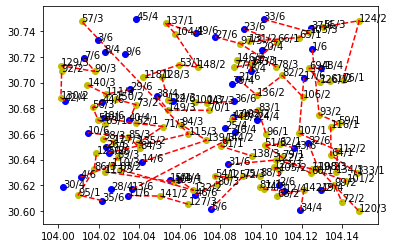

In [ ]:
fig, ax = plt.subplots()
for e, p in enumerate(points[1:]):
    if is_driver(p):
        ax.scatter(p["coordinate"][0],p["coordinate"][1],c = 'b')
        ax.annotate(str(e+1)+"/"+str(p["sites"]), (p["coordinate"][0],p["coordinate"][1]))
    else:
        ax.scatter(p["coordinate"][0],p["coordinate"][1],c = 'y')
        ax.annotate(str(e+1)+"/"+str(p["size"]), (p["coordinate"][0],p["coordinate"][1]))

for line in table:
    if len(p)>1:
        coordinates = [points[i]["coordinate"] for i in line]
        x, y = zip(*coordinates)
        ax.plot(x,y,'r--')